# Dataset

In [2]:
DATASET = {'20Hz_protocol':[\
                              {'Control':['nm02Mar2018c0_000_ctrl.h5'],
                               'Tricine':['nm02Mar2018c0_001_tricine.h5']},
                              {'Control':['nm02Mar2018c1_000_ctrl.h5'],
                               'Tricine':['nm02Mar2018c1_002_tricine.h5']},
                              {'Control':['nm02Mar2018c2_000_ctrl.h5'],
                               'Tricine':['nm02Mar2018c2_002_tricine.h5']},
                              {'Control':['nm30Mar2018c1_000_ctrl.h5'],
                               'Tricine':['nm30Mar2018c1_004_tricine.h5']},
                              #{'Control':['nm17Apr2019c1_000.h5'],
                              # 'Tricine':['nm17Apr2019c1_001.h5']},
                            ],
           '3Hz_protocol':[\
                             {'Control':['nm18Sep2019c1_000.h5'],
                              'Tricine':['nm18Sep2019c1_001.h5']},
                             {'Control':['nm19Sep2019c1_001.h5'],
                              'Tricine':['nm19Sep2019c1_002.h5']},
                             {'Control':['nm20Sep2019c1_001.h5'],
                              'Tricine':['nm20Sep2019c1_003.h5']},
                             #{'Control':['nm30Aug2019c0_000.h5'],
                             # 'Tricine':['nm30Aug2019c0_002.h5']},
                             {'Control':['nm18Sep2019c4_000.h5'],
                              'Tricine':['nm18Sep2019c4_003.h5']},
                             {'Control':['nm19Sep2019c2_001.h5'],
                              'Tricine':['nm19Sep2019c2_004.h5']},
                             {'Control':['nm23Sep2019c2_001.h5'],
                              'Tricine':['nm23Sep2019c2_002.h5']},
            ],
}

PROPERTIES = {} # This will store the analysis results
def add_to(PROPERTIES, key, dtype=float):
    PROPERTIES[key] = {}
    for k in DATASET:
        PROPERTIES[key][k] = []
        for d in DATASET[k]:
            new_d = {}
            for kk in d:
                new_d[kk] = np.zeros(len(d[kk]), dtype=dtype)
            PROPERTIES[key][k].append(new_d)
# e.g use as: "add_to(PROPERTIES, 'Rm', dtype=float)"


In [3]:
import os, sys
import numpy as np
from analyz.IO.igor import load_hdf5_exported_from_Igor as load_data
from analyz.processing.filters import butter_lowpass_filter
%matplotlib inline
from datavyz import gedn as ge

In [4]:

def abbrev_to_month(abbrev):
    M = ['January', 'February', 'March', 'April', 'May',\
         'June', 'July', 'August', 'September', 'October',\
         'November', 'December']
    for m in M:
        if (m[:3].lower()==abbrev.lower()):
            return m

        
def filename_to_path(filename):
    day, month, year = filename[2:4], filename[4:7], filename[7:11]
    cell = filename[11:13]
    cond = filename[14:17]
    return os.path.join(year, abbrev_to_month(month), filename[:13], filename)


def plot_protocol(D, tzoom=[0, np.inf]):
    fig, AX = ge.figure(axes_extents=[[[3,1]] for i in range(3)]+[[[3,3]]], hspace=0.3, figsize=(1,.6))
    tcond = (D['t']>=tzoom[0]) & (D['t']<tzoom[1])
    ge.title(AX[0], D['filename'].split(os.path.sep)[-1])
    ge.plot(1e-3*D['t'][tcond], D['stimulations'][D['Vcmd_key']][tcond],
            ax=AX[0], axes_args={'spines':['left'], 'ylabel':'Vcmd (mV)'})
    ge.plot(1e-3*D['t'][tcond], D['stimulations'][D['stim_key']][tcond],
            ax=AX[1], axes_args={'spines':['left'], 'ylabel':'Stim (V)'})
    for i in range(D['recordings'][D['Irec_key']].shape[0]):
        AX[2].plot(1e-3*D['t'][tcond], D['recordings'][D['Irec_key']][i,tcond],
                   color='lightgray', lw=0.3) 
    ge.plot(1e-3*D['t'][tcond], D['recordings'][D['Irec_key']].mean(axis=0)[tcond],
            ax=AX[2], axes_args={'spines':['left'], 'ylabel':'raw I (nA)'})
    # now blanking the stimulus period
    for i in range(D['recordings'][D['Irec_key']].shape[0]):
        AX[3].plot(1e-3*D['t'][tcond], D['recordings']['Irecording_clean'][i,tcond],
                   color='lightgray', lw=0.3) 
    ge.plot(1e-3*D['t'][tcond], D['recordings']['Irecording_clean'].mean(axis=0)[tcond],
            ax=AX[3], axes_args={'xlabel':'time (s)', 'ylabel':'I (nA)'})

    
def LoadData(protocol,
             iexp=0, condition='Control', irec=0,
             dt_subampling=0,
             Fcutoff = 2000., # for low pass filtering
             verbose=False):
    if sys.platform=='win32': # Windows
        root_folder = 'C:\\'
    else:
        root_folder = '/media/yann/Windows'
    root_folder = os.path.join(root_folder, 'Users', 'yann.zerlaut', 'Documents', 'DATA', 'Data_Nunzio')

    fn = os.path.join(root_folder, filename_to_path(DATASET[protocol][iexp][condition][irec]))
    try:
        data = load_data(fn, dt_subsampling=dt_subampling, verbose=verbose)
        data['filename'] = fn
        if 'stim' in data['stimulations']:
            data['stim_key'] = 'stim'
        else:
            data['stim_key'] = 'Stimulator'
        if 'Vcommand2' in data['stimulations']:
            data['Vcmd_key'] = 'Vcommand2'
        else:
            data['Vcmd_key'] = 'Vcommand'
        if 'Irecording2' in data['recordings']:
            data['Irec_key'] = 'Irecording2'
        else:
            data['Irec_key'] = 'Irecording'
    except (UnboundLocalError, KeyError):
        print('/!\ -- File corrupted ! -- /!\ ')
        print(fn)
        from analyz.IO.hdf5 import load_dict_from_hdf5
        data = load_dict_from_hdf5(fn)
    if Fcutoff>0:
        # adding low pass filtering
        Facq = 1./(data['t'][1]-data['t'][0])*1e3
        for i in range(data['recordings'][data['Irec_key']].shape[0]):
            data['recordings'][data['Irec_key']][i,:] =\
                butter_lowpass_filter(data['recordings'][data['Irec_key']][i,:], Fcutoff, Facq, order=5)
        
    data = remove_stimulation_artefact(data)
        
    return data

def remove_stimulation_artefact(D,
                                Tborder=2, # both in ms
                                Twindow=0.01):
    """
    For comparison with the theoretical model, the electrical artefact following extracellular stimulation in the voltage-clamp recordings was removed. This was performed by replacing the values during stimulation (TTL>0mV) by a linear interpolation of the signal using the pre- and post-stimulus recorded value.
    """
    iborder = int(Tborder/(D['t'][1]-D['t'][0])) # Tborder & t in ms
    iwindow = int(Twindow/(D['t'][1]-D['t'][0])) # Tborder & t in ms
    D['recordings']['Irecording_clean'] = 1.*D['recordings'][D['Irec_key']]
    rounded_stim = np.round(D['stimulations'][D['stim_key']],0)
    threshold = np.mean(np.unique(rounded_stim))/2.
    iup = np.argwhere((rounded_stim[1:]>threshold) & (rounded_stim[:-1]<=threshold)).flatten()
    idown = np.argwhere((rounded_stim[1:]<=threshold) & (rounded_stim[:-1]>=threshold)).flatten()

    for i0, i1 in zip(iup, idown):
        Y0 = D['recordings'][D['Irec_key']][:,i0-iborder-iwindow:i0-iborder].mean(axis=1)
        Y1 = D['recordings'][D['Irec_key']][:,i1+iborder:i1+iborder+iwindow].mean(axis=1)
        for i in range(i0-iborder, i1+iborder):
            # linear interpolation with respect to stimulus borders
            D['recordings']['Irecording_clean'][:,i] = Y0+(Y1-Y0)*(i-(i0-iborder))/(i1-i0+2*iborder)
    return D



In [5]:
## Importing electrophy/intracellular module
import sys
sys.path.append('/home/yann/work/cortical-physio-icm') # append CPI to your path to be able to import
from electrophy.intracellular.passive_props import extract_VCcharact, from_VCcharact_to_membrane_parameters

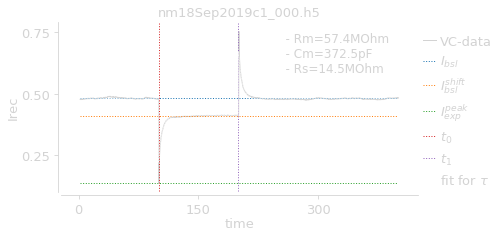

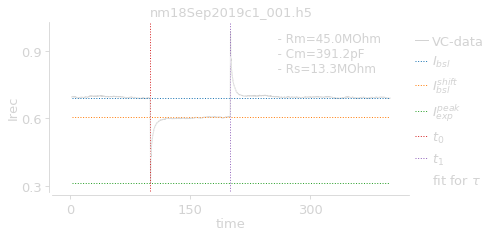

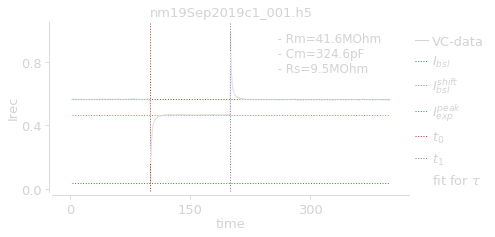

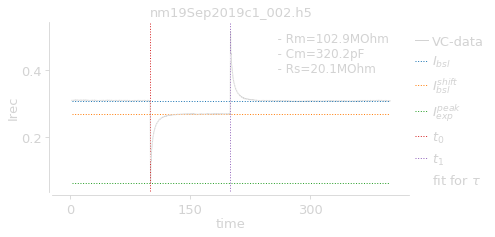

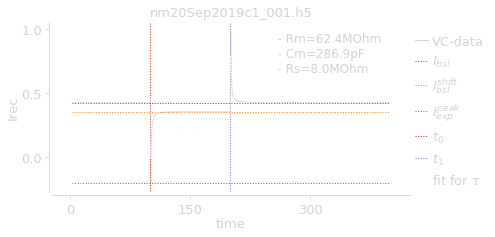

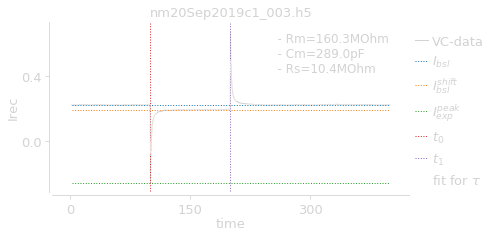

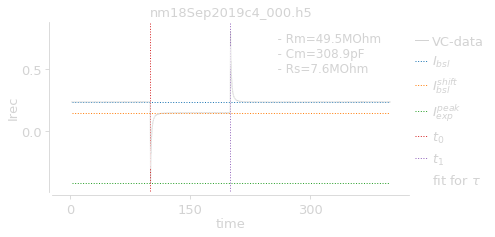

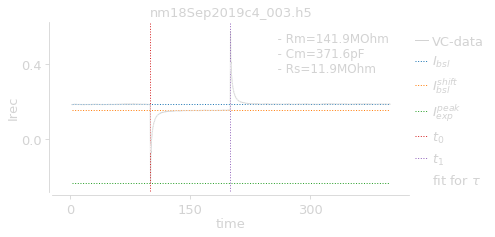

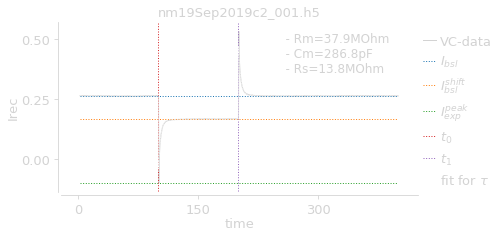

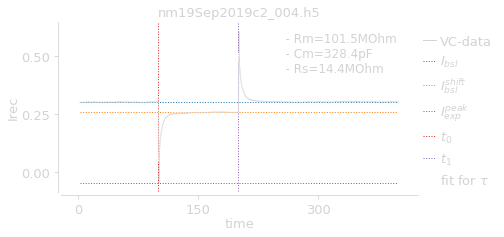

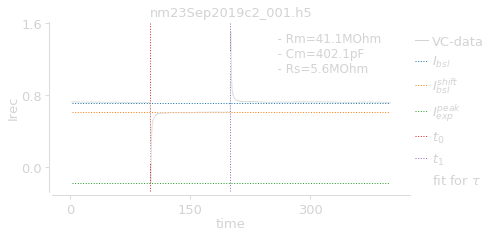

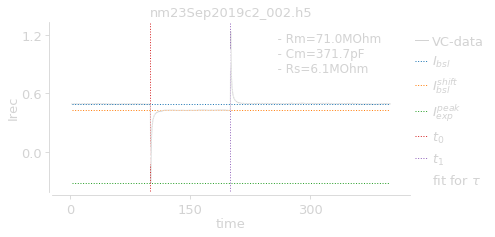

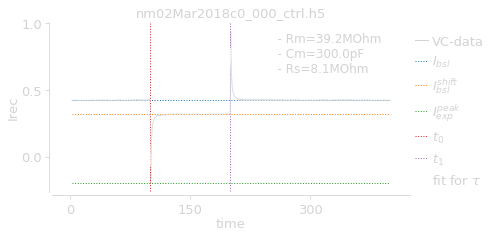

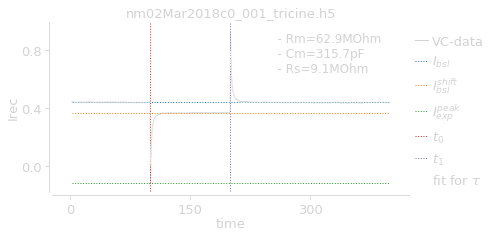

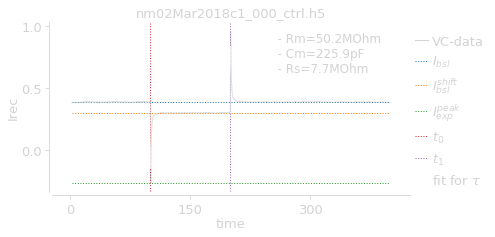

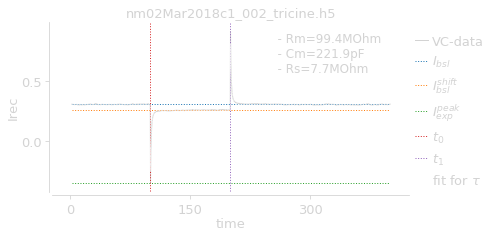

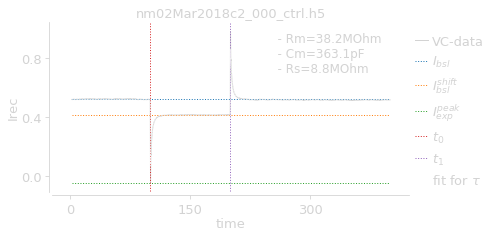

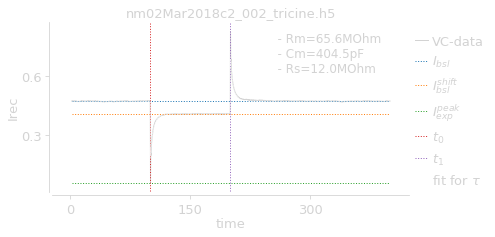

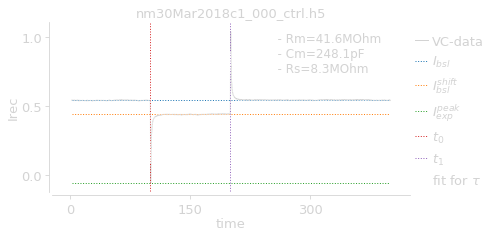

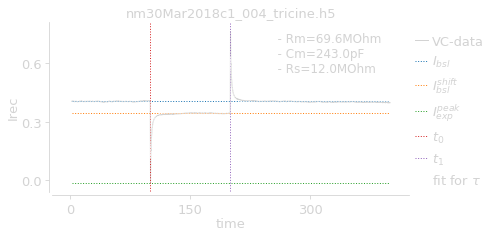

In [7]:
from scipy.optimize import minimize

add_to(PROPERTIES, 'Rm', dtype=float)
add_to(PROPERTIES, 'Cm', dtype=float)
add_to(PROPERTIES, 'Rs', dtype=float)

cond = '3Hz_protocol'

for prtcl in ['3Hz_protocol', '20Hz_protocol']:
    for i, cell in enumerate(DATASET[prtcl]):
        for cond in ['Control', 'Tricine']:
            data = LoadData(prtcl, iexp=i, condition=cond)

            t = data['t']
            tcond = (t>2) & (t<400)
            trace = data['recordings'][data['Irec_key']].mean(axis=0)
            fig, ax, IbslShift, IexpPeak, Tau = extract_VCcharact(t[tcond], trace[tcond],
                                                                  t0=100, t1=200,
                                                                  with_plot=True, ge=ge,
                                                    title=data['filename'].split(os.path.sep)[-1])
            Rm, Cm, Rs = from_VCcharact_to_membrane_parameters(1e-9*IbslShift, 1e-9*IexpPeak, 1e-3*Tau)
            ge.annotate(ax, """
            - Rm=%.1fMOhm
            - Cm=%.1fpF
            - Rs=%.1fMOhm
            """ % (1e-6*Rm, 1e12*Cm, 1e-6*Rs), (.5,.6), size='small')
            PROPERTIES['Rm'][prtcl][i][cond][0] = Rm
            PROPERTIES['Cm'][prtcl][i][cond][0] = Cm
            PROPERTIES['Rs'][prtcl][i][cond][0] = Rs
    


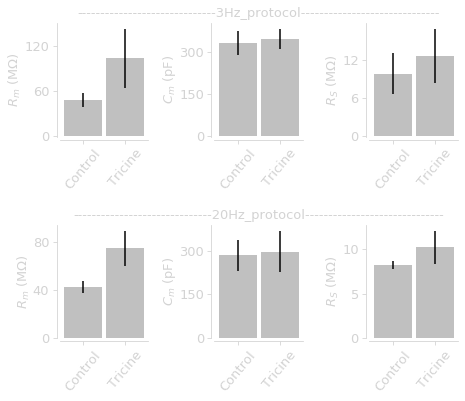

In [8]:
Rm, Cm, Rs = {}, {}, {}

fig, AX = ge.figure(axes=(3,2), figsize=(.7,1.), wspace=1.3, hspace=1.3)

Rm[cond], Cm[cond], Rs[cond] = [], [], []


for prtcl, axs in zip(['3Hz_protocol', '20Hz_protocol'], AX):
    
    for cond in ['Control', 'Tricine']:
        Rm[cond], Cm[cond], Rs[cond] = [], [], []
        
    for i, cell in enumerate(DATASET[prtcl]):
        for cond in ['Control', 'Tricine']:
            Rm[cond].append(PROPERTIES['Rm'][prtcl][i][cond][0])
            Cm[cond].append(PROPERTIES['Cm'][prtcl][i][cond][0])
            Rs[cond].append(PROPERTIES['Rs'][prtcl][i][cond][0])

    ge.bar([1e-6*np.array(Rm[cond]).mean() for cond in ['Control', 'Tricine']],
           sy=[1e-6*np.array(Rm[cond]).std() for cond in ['Control', 'Tricine']],
           axes_args=dict(xticks_labels=['Control', 'Tricine'], xticks=[0,1],
                          xticks_rotation=50, ylabel='$R_m$ (M$\Omega$)'),
           ax=axs[0])
    ge.bar([1e12*np.mean(Cm[cond]) for cond in ['Control', 'Tricine']],
           sy=[1e12*np.std(Cm[cond]) for cond in ['Control', 'Tricine']],
           axes_args=dict(xticks_labels=['Control', 'Tricine'], xticks=[0,1],
                          xticks_rotation=50, ylabel='$C_m$ (pF)'),
           ax=axs[1])
    ge.bar([1e-6*np.array(Rs[cond]).mean() for cond in ['Control', 'Tricine']],
           sy=[1e-6*np.array(Rs[cond]).std() for cond in ['Control', 'Tricine']],
           axes_args=dict(xticks_labels=['Control', 'Tricine'], xticks=[0,1],
                          xticks_rotation=50, ylabel='$R_S$ (M$\Omega$)'),
           ax=axs[2])
    ge.title(axs[1], 30*'-'+prtcl+30*'-')
    

In [14]:
# merging protocols
Rm, Cm, Rs = {}, {}, {}
for cond in ['Control', 'Tricine']:
    Rm[cond], Cm[cond], Rs[cond] = [], [], []
for prtcl, axs in zip(['3Hz_protocol', '20Hz_protocol'], AX):
    for i, cell in enumerate(DATASET[prtcl]):
        for cond in ['Control', 'Tricine']:
            Rm[cond].append(PROPERTIES['Rm'][prtcl][i][cond][0])
            Cm[cond].append(PROPERTIES['Cm'][prtcl][i][cond][0])
            Rs[cond].append(PROPERTIES['Rs'][prtcl][i][cond][0])
print('Rm=%.2f+/-%.2f MOhm,\nCm=%.2f+/-%.2f pF' % (1e-6*np.array(Rm['Control']).mean(),
                                                    1e-6*np.array(Rm['Control']).std(),
                                                    1e12*np.array(Cm['Control']).mean(),
                                                    1e12*np.array(Cm['Control']).std()))    

Rm=45.89+/-8.15 MOhm,
Cm=311.89+/-52.40 pF


### Finding the passive props in the model

In [21]:
N = 10
GRID = {'gl':np.linspace(0.05, 10., N),
        'cm':np.linspace(0.5, 2., N)}
np.savez(os.path.join('data', 'calib', 'passive-grid.npz'), **GRID)

In [3]:
import os
from analyz.workflow.batch_run import slurm_script, bash_script, GridSimulation
from analyz.IO.npz import load_dict

sim = GridSimulation(os.path.join('data', 'calib', 'passive-grid.npz'))
bs = bash_script('calib-passive')
bs.script = sim.build_script('python passive_props.py calib', base_script=bs.script)
bs.write(folder='./bash/')


In [ ]:
cond = '3Hz_protocol'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    plot_protocol(data_ctrl)
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    plot_protocol(data_test)

In [46]:
def compute_norm_trace(data,
                       window_for_peak=20, # ms
                       pre_window = 150, # ms
                       t0=400,
                       with_all=False):

    tcond = (data['t']>t0-pre_window)
    baseline_cond = (data['t']>t0-pre_window) & (data['t']<t0)
    baseline = data['recordings']['Irecording_clean'].mean(axis=0)[baseline_cond].mean()

    trace = data['recordings']['Irecording_clean'].mean(axis=0)[tcond]-baseline
    stim = data['stimulations'][data['stim_key']][tcond]
    stim_events = np.argwhere((stim[:-1]<2) & (stim[1:]>=2)).flatten()
    peak_cond = (data['t'][tcond]>=t0) & (data['t'][tcond]<=t0+window_for_peak)

    norm_trace = trace/np.max(trace[peak_cond])

    if with_all:
        return data['t'][tcond], stim_events, norm_trace, np.max(trace[peak_cond])
    else:
        return norm_trace

    
def protocol_comparison(DATA,
                        labels=['Control', 'Tricine'],
                        colors=['k', ge.green],
                        window_for_peak=20, # ms
                        pre_window = 150, # ms
                        t0=400):
    fig, AX = ge.figure(axes=(1,3), figsize=(2,1.3), hspace=0.3)
    for data, c in zip(DATA, colors):
        AX[0].plot(1e-3*data['t'], data['recordings'][data['Irec_key']].mean(axis=0), color=c)
    ge.set_plot(AX[0], ['left'], ylabel='raw-I (nA)')

    for data, label, c in zip(DATA, labels, colors):
        tcond = (data['t']>t0-pre_window)
        baseline_cond = (data['t']>t0-pre_window) & (data['t']<t0)
        baseline = data['recordings']['Irecording_clean'].mean(axis=0)[baseline_cond].mean()
        trace = data['recordings']['Irecording_clean'].mean(axis=0)[tcond]-baseline
        
        peak_cond = (data['t'][tcond]>t0) & (data['t'][tcond]<t0+window_for_peak)
        norm_trace = compute_norm_trace(data, window_for_peak, pre_window, t0)
        
        AX[1].plot(1e-3*data['t'][tcond], trace, color=c, label=label)
        AX[2].plot(1e-3*data['t'][tcond], norm_trace, color=c, label=label)
        
    ge.set_plot(AX[1], ['left'], ylabel='I (nA)\n (-baseline&stim)')
    ge.set_plot(AX[2], xlabel='time (s)', ylabel='I (nA)\n (-baseline&stim)\n (+rescaled)')
    
    ge.legend(AX[1])
    return fig, AX


# Extracellular stimulation

In [ ]:
cond = '3Hz_protocol'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    protocol_comparison([data_ctrl, data_test])

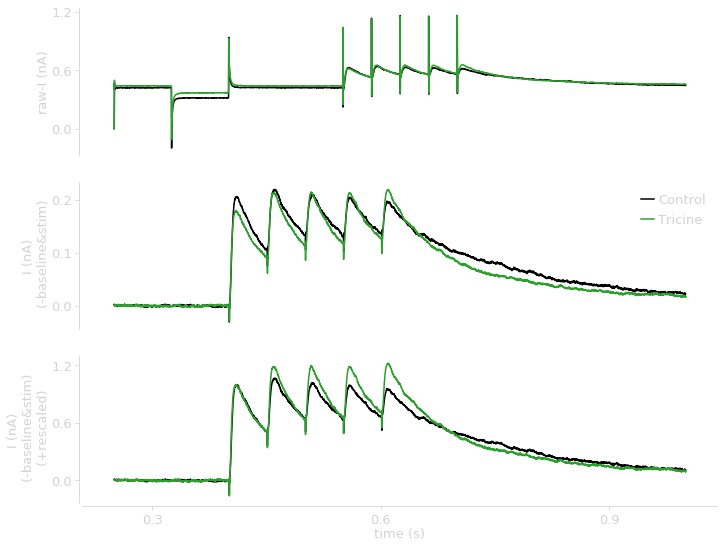

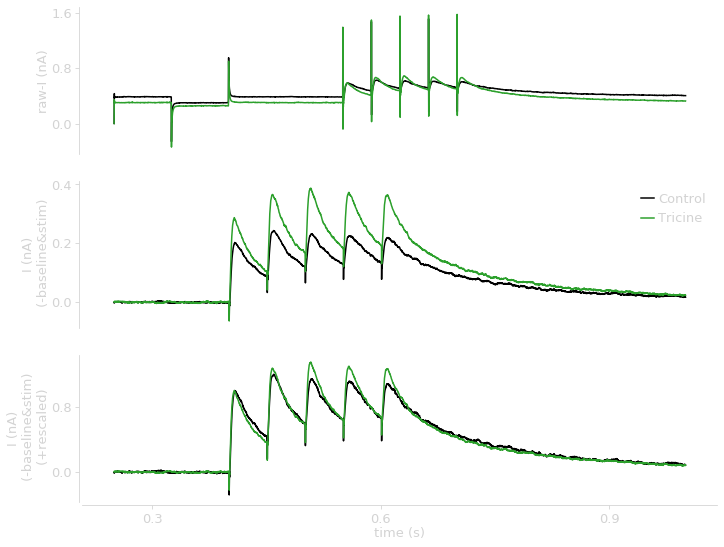

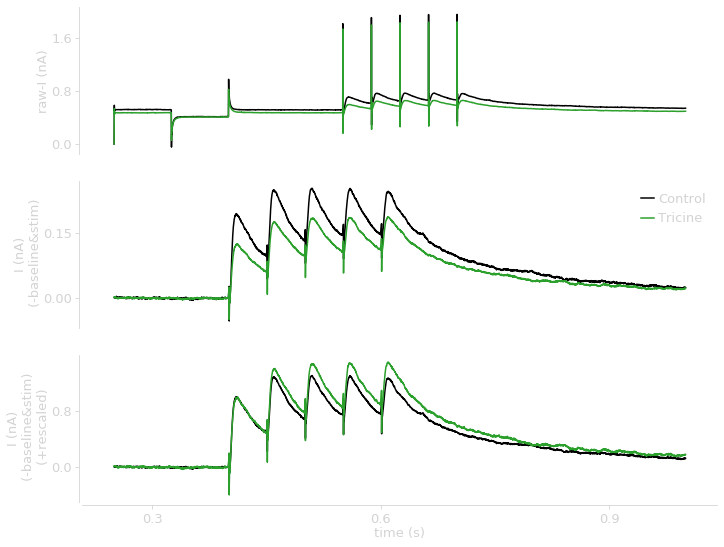

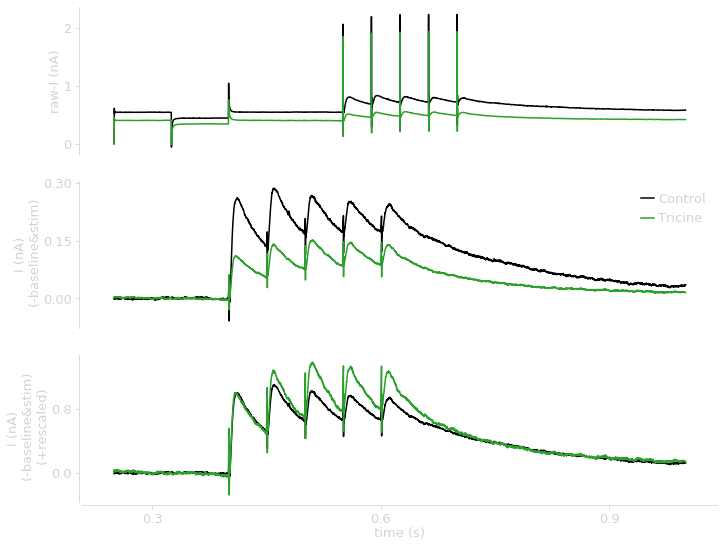

In [292]:
cond = '20Hz_protocol'
for i, cell in enumerate(DATASET[cond]):
    data_ctrl = LoadData(cond, iexp=i, condition='Control')
    data_test = LoadData(cond, iexp=i, condition='Tricine')
    protocol_comparison([data_ctrl, data_test])

In [47]:

FDATA = {}
for cond in ['3Hz_protocol', '20Hz_protocol']:
    norm_trace_ctrl, norm_trace_test = [], []
    scale_ctrl, scale_test = [], []
    for i, cell in enumerate(DATASET[cond]):
        data_ctrl = LoadData(cond, iexp=i, condition='Control')
        t, se, n_trace, scale = compute_norm_trace(data_ctrl,
                                            window_for_peak=20,
                                            pre_window = 150,
                                            t0=400, with_all=True)
        norm_trace_ctrl.append(n_trace)
        scale_ctrl.append(scale)
        data_test = LoadData(cond, iexp=i, condition='Tricine')
        t, se, n_trace, scale = compute_norm_trace(data_test,
                                            window_for_peak=20,
                                            pre_window = 150,
                                            t0=400, with_all=True)
        norm_trace_test.append(n_trace)
        scale_test.append(scale)
    FDATA[cond] = {'norm_trace_ctrl':np.array(norm_trace_ctrl),
                   'norm_trace_test':np.array(norm_trace_test),
                   't':t,
                   'se':se,
                   'scale_ctrl':np.array(scale_ctrl),
                   'scale_test':np.array(scale_test)}


In [48]:
# toy model data

def build_stimulation():
    
    dt, tstop = 0.1, 5000.
    t = np.arange(int(tstop/dt))*dt
    model = {'t':t}
    events = np.empty(0)
    for cond, t0, freq_pulses, n_pulses in zip(['20Hz_protocol', '3Hz_protocol'],
                                               [500,1700], [20., 3.], [5, 9]) :

        new_events = t0+np.arange(n_pulses)*1e3/freq_pulses
        events = np.concatenate([events, new_events])
        model['%s_tstart' % cond] = t0
    model['events'] = events
    return model

model = build_stimulation()



In [49]:
from datavyz import gedn as ge

In [50]:

calibration_constraints = {}
for cond, ax in zip(['20Hz_protocol', '3Hz_protocol'], AX):
    
    ## exp
    DT0 = FDATA[cond]['t'][FDATA[cond]['se'][0]]-FDATA[cond]['t'][0]
    DTfull = FDATA[cond]['t'][-1]-FDATA[cond]['t'][0]
    new_t = FDATA[cond]['t'][::10][:-1]-FDATA[cond]['t'][0]
    calibration_constraints['DT0_%s' % cond] = DT0
    calibration_constraints['DTfull_%s' % cond] = FDATA[cond]['t'][-1]-FDATA[cond]['t'][0]
    calibration_constraints['t_%s' % cond] = new_t

    # tricine cond
    te0 = FDATA[cond]['norm_trace_test'].mean(axis=0)*1e3*FDATA[cond]['scale_test'].mean()
    trace_exp = te0[::10][:-1] # subsampling at 1kHz
    calibration_constraints['Iexp_chelated_%s' % cond] = trace_exp
    
    # control cond
    te0 = FDATA[cond]['norm_trace_ctrl'].mean(axis=0)*1e3*FDATA[cond]['scale_ctrl'].mean()
    trace_exp = te0[::10][:-1] # subsampling at 1kHz
    calibration_constraints['Iexp_zinc_%s' % cond] = trace_exp
    
np.savez('data/exp_data_for_calibration.npz', **calibration_constraints)


## Perform calibration on Tricine case: chelated Zinc

In [1]:
import numpy as np
import itertools, os

In [87]:
passive = np.load('data/passive-props.npz')
passive['gl']

array(1.07931034)

In [103]:
GRID = {'Tnmda':[65, 120],
        'Nsyn1':[40, 100],
        'Nsyn2':[40, 80],
        'Tnsyn':[500, 1500]}

Ngrid = 5
Nsimultaneous = 100
from analyz.workflow.batch_run import slurm_script, bash_script, GridSimulation
from analyz.workflow.batch_run import GridSimulation

np.savez(os.path.join('data', 'calib', 'chelated-zinc-calib-grid.npz'), **GRID)
sim = GridSimulation(GRID)

ss = slurm_script('calib-chelated-zinc', nodes=1, partition='normal', mem='10G', time='5:00:00')
bs = bash_script('calib-chelated-zinc')
i=0
for i in range(sim.N):
    instruct += 'python calibration-runs.py chelated-zinc-calib %i' % i
    if not (i%Nsimultaneous==(Nsimultaneous-1)):
        instruct+='&'
    ss.append_instruction(instruct)
    bs.append_instruction(instruct)
    i+=1
ss.append_instruction(instruct[:-1])
bs.append_instruction(instruct[:-1])
# then we wrap up the data
instruct = 'python calibration-runs.py chelated-zinc-calib-wrapup-data')
ss.append_instruction(instruct)
bs.append_instruction(instruct)

ss.write(folder='./batch/')
bs.write(folder='./bash/')

### Find minimum

In [79]:
calib_data = load_dict('data/exp_data_for_calibration.npz')
full_data = load_dict('data/chelated-zinc-calib-full-data.npz')

def compute_residual(i, full_data):
    Residual = 0
    for cond in ['20Hz_protocol', '3Hz_protocol']:
        tcond = (full_data['t']>(full_data['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
            (full_data['t']<full_data['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
             calib_data['DTfull_%s' % cond])
        trace_model = 1e3*(full_data['Ic'][i][tcond]-full_data['Ic'][i][tcond][0])
        trace_exp = calib_data['Iexp_chelated_%s' % cond]
        Residual += np.sum((trace_model-trace_exp)**2)/len(calib_data['t_%s' % cond])
    return Residual

Residuals = np.ones(len(full_data['Ic']))*np.inf
for i in range(len(full_data['Ic'])):
    Residuals[i] = compute_residual(i, full_data)

imin = np.argmin(Residuals)
print(Residuals[imin])
best_chelated_config = {'filename':full_data['filename'][i],
                        'Tnmda':full_data['Tnmda'][i],
                        'Nsyn1':full_data['Nsyn1'][i],
                        'Nsyn2':full_data['Nsyn2'][i],
                        'Tnsyn':full_data['Tnsyn'][i]}
np.savez('data/best_chelated_config.npz', **best_chelated_config)    
print(best_chelated_config)

338.7910943808481
{'filename': 'data/calib/chelated-zinc/130.0-100-100-1500.0.npz', 'Tnmda': 130.0, 'Nsyn1': 100.0, 'Nsyn2': 100.0, 'Tnsyn': 1500.0}


### Calibration results: chelated-Zinc

6031.383368137435


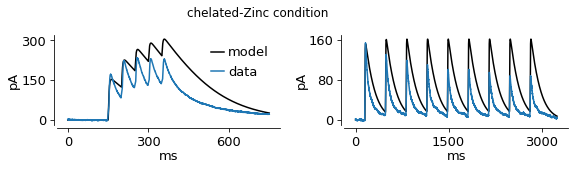

In [80]:
from datavyz import gen as ge
from analyz.IO.npz import load_dict

fig, AX = ge.figure(axes=(2,1), figsize=(1.2,0.8),
                    wspace=0.5, hspace=0)
Residual = 0

calib_data = load_dict('data/exp_data_for_calibration.npz')

best_chelated_config = load_dict('data/best_chelated_config.npz')    
#mdata = load_dict(os.path.join('data', 'calib', 'chelated-zinc', best_chelated_config))
mdata = load_dict(best_chelated_config['filename'])

for cond, ax in zip(['20Hz_protocol', '3Hz_protocol'], AX):
    ## data
    tcond = (mdata['t']>(mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
        (mdata['t']<mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
         calib_data['DTfull_%s' % cond])
    
    trace_model = 1e3*(mdata['Ic'][tcond]-mdata['Ic'][tcond][0])

    trace_exp = calib_data['Iexp_chelated_%s' % cond]
    
    Residual += np.sum((trace_model-trace_exp)**2)/len(calib_data['t_%s' % cond]) # normalized by sample size
    ax.plot(calib_data['t_%s' % cond], trace_model, color=ge.default_color, label='model')
    ax.plot(calib_data['t_%s' % cond], trace_exp, color=ge.blue, label='data')

    ge.set_plot(ax, ylabel='pA', xlabel='ms')
ge.legend(AX[0])
fig.suptitle('chelated-Zinc condition', color=ge.default_color)
print(Residual)


## Perform calibration on control case: free-Zinc

In [1]:
import itertools, os
import numpy as np
from analyz.workflow.batch_run import slurm_script, bash_script, GridSimulation

Ngrid=2
GRID = {'alphaZn': np.linspace(0.3, 0.7, Ngrid),
        'tauRiseZn':np.logspace(np.log10(1), np.log10(40), Ngrid),
        'tauDecayZn':np.logspace(np.log10(20), np.log10(500), Ngrid),
        'Deltax0':np.linspace(0.3, 0.7, Ngrid),
        'deltax':np.linspace(0.05, 0.3, Ngrid)}

np.savez(os.path.join('data', 'calib', 'chelated-zinc-calib-grid.npz'), **GRID)

# ss = slurm_script('calib-free-zinc', nodes=1, partition='bigmem', mem='20G')
# bs = bash_script('calib-free-zinc')

# i=0
# for alphaZn, tauRiseZn, tauDecayZn, Deltax0, deltax in itertools.product(\
#                                                 np.linspace(*GRID['alphaZn'], Ngrid),\
#                                                 np.logspace(*GRID['tauRiseZn'], Ngrid),\
#                                                 np.logspace(*GRID['tauDecayZn'], Ngrid),\
#                                                 np.linspace(*GRID['Deltax0'], Ngrid),\
#                                                 np.linspace(*GRID['deltax'], Ngrid)):

#     instructions = 'python calibration-runs.py Zinc-calib %.2f %.1f %.1f %.2f %.2f' % (alphaZn, tauRiseZn, tauDecayZn, Deltax0, deltax)
#     fn = os.path.join('data', 'calib', 'free-zinc', '%.2f-%.1f-%.1f-%.2f-%.2f.npz' % (alphaZn, tauRiseZn, tauDecayZn, Deltax0, deltax))
#     if i%10==0:
#         bs.append_instruction(instruct)
#     else:
#         bs.append_instruction(instruct+' &')
#     i+=1
# ss.write(folder='./batch/')
# bs.write(folder='./bash/')
        

In [190]:

Ngrid=2
GRID = {'alphaZn': np.linspace(0.3, 0.7, Ngrid),
        'tauRiseZn':np.logspace(np.log10(1), np.log10(40), Ngrid),
        'tauDecayZn':np.logspace(np.log10(20), np.log10(500), Ngrid),
        'Deltax0':np.linspace(0.3, 0.7, Ngrid),
        'deltax':np.linspace(0.05, 0.3, Ngrid)}


        

In [2]:
import itertools
Ngrid=2

GRID = {'alphaZn': np.linspace(0.3, 0.7, 4),
        'tauRiseZn':np.logspace(np.log10(1), np.log10(40), 3),
        'tauDecayZn':np.logspace(np.log10(20), np.log10(500), 2),
        'Deltax0':np.linspace(0.3, 0.7, 5),
        'deltax':np.linspace(0.05, 0.3, 6)}


sim = GridSimulation(GRID)
from model import Model
for i, vals in enumerate(itertools.product(*[GRID[key] for key in GRID.keys()])):
    print(i, ')', *vals)
    Is = sim.compute_indices(i) 
    print(Is)
    sim.update_dict_from_GRID_and_index(i, Model)
    print(sim.params_filename(i, formatting=['%.1f', '%.2f', '%.2f', '%i', '%.0f']))


0 ) 0.3 1.0 20.000000000000004 0.3 0.05
[0 0 0 0 0]
alphaZn_0.3--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
1 ) 0.3 1.0 20.000000000000004 0.3 0.1
[0 0 0 0 1]
alphaZn_0.3--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
2 ) 0.3 1.0 20.000000000000004 0.3 0.15000000000000002
[0 0 0 0 2]
alphaZn_0.3--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
3 ) 0.3 1.0 20.000000000000004 0.3 0.2
[0 0 0 0 3]
alphaZn_0.3--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
4 ) 0.3 1.0 20.000000000000004 0.3 0.25
[0 0 0 0 4]
alphaZn_0.3--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
5 ) 0.3 1.0 20.000000000000004 0.3 0.3
[0 0 0 0 5]
alphaZn_0.3--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
6 ) 0.3 1.0 20.000000000000004 0.39999999999999997 0.05
[0 0 0 1 0]
alphaZn_0.3--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
7 ) 0.3 1.0 20.000000000000004 0.39999999999999997 0.1
[0 0 0 1 1]
alphaZn_0.3--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
8 ) 0

alphaZn_0.4--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
194 ) 0.43333333333333335 1.0 20.000000000000004 0.5 0.15000000000000002
[1 0 0 2 2]
alphaZn_0.4--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
195 ) 0.43333333333333335 1.0 20.000000000000004 0.5 0.2
[1 0 0 2 3]
alphaZn_0.4--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
196 ) 0.43333333333333335 1.0 20.000000000000004 0.5 0.25
[1 0 0 2 4]
alphaZn_0.4--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
197 ) 0.43333333333333335 1.0 20.000000000000004 0.5 0.3
[1 0 0 2 5]
alphaZn_0.4--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
198 ) 0.43333333333333335 1.0 20.000000000000004 0.6 0.05
[1 0 0 3 0]
alphaZn_0.4--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
199 ) 0.43333333333333335 1.0 20.000000000000004 0.6 0.1
[1 0 0 3 1]
alphaZn_0.4--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
200 ) 0.43333333333333335 1.0 20.000000000000004 0.6 0.15000000000000002
[1 0 0 3 2]
alphaZn_0.4--t

[2 0 0 0 5]
alphaZn_0.6--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
366 ) 0.5666666666666667 1.0 20.000000000000004 0.39999999999999997 0.05
[2 0 0 1 0]
alphaZn_0.6--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
367 ) 0.5666666666666667 1.0 20.000000000000004 0.39999999999999997 0.1
[2 0 0 1 1]
alphaZn_0.6--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
368 ) 0.5666666666666667 1.0 20.000000000000004 0.39999999999999997 0.15000000000000002
[2 0 0 1 2]
alphaZn_0.6--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
369 ) 0.5666666666666667 1.0 20.000000000000004 0.39999999999999997 0.2
[2 0 0 1 3]
alphaZn_0.6--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
370 ) 0.5666666666666667 1.0 20.000000000000004 0.39999999999999997 0.25
[2 0 0 1 4]
alphaZn_0.6--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax_0
371 ) 0.5666666666666667 1.0 20.000000000000004 0.39999999999999997 0.3
[2 0 0 1 5]
alphaZn_0.6--tauRiseZn_1.00--tauDecayZn_20.00--Deltax0_0--deltax

alphaZn_0.6--tauRiseZn_40.00--tauDecayZn_20.00--Deltax0_0--deltax_0
483 ) 0.5666666666666667 40.000000000000014 20.000000000000004 0.3 0.2
[2 2 0 0 3]
alphaZn_0.6--tauRiseZn_40.00--tauDecayZn_20.00--Deltax0_0--deltax_0
484 ) 0.5666666666666667 40.000000000000014 20.000000000000004 0.3 0.25
[2 2 0 0 4]
alphaZn_0.6--tauRiseZn_40.00--tauDecayZn_20.00--Deltax0_0--deltax_0
485 ) 0.5666666666666667 40.000000000000014 20.000000000000004 0.3 0.3
[2 2 0 0 5]
alphaZn_0.6--tauRiseZn_40.00--tauDecayZn_20.00--Deltax0_0--deltax_0
486 ) 0.5666666666666667 40.000000000000014 20.000000000000004 0.39999999999999997 0.05
[2 2 0 1 0]
alphaZn_0.6--tauRiseZn_40.00--tauDecayZn_20.00--Deltax0_0--deltax_0
487 ) 0.5666666666666667 40.000000000000014 20.000000000000004 0.39999999999999997 0.1
[2 2 0 1 1]
alphaZn_0.6--tauRiseZn_40.00--tauDecayZn_20.00--Deltax0_0--deltax_0
488 ) 0.5666666666666667 40.000000000000014 20.000000000000004 0.39999999999999997 0.15000000000000002
[2 2 0 1 2]
alphaZn_0.6--tauRiseZn_40.00

[3 2 1 1 5]
alphaZn_0.7--tauRiseZn_40.00--tauDecayZn_500.00--Deltax0_0--deltax_0
702 ) 0.7 40.000000000000014 499.99999999999994 0.5 0.05
[3 2 1 2 0]
alphaZn_0.7--tauRiseZn_40.00--tauDecayZn_500.00--Deltax0_0--deltax_0
703 ) 0.7 40.000000000000014 499.99999999999994 0.5 0.1
[3 2 1 2 1]
alphaZn_0.7--tauRiseZn_40.00--tauDecayZn_500.00--Deltax0_0--deltax_0
704 ) 0.7 40.000000000000014 499.99999999999994 0.5 0.15000000000000002
[3 2 1 2 2]
alphaZn_0.7--tauRiseZn_40.00--tauDecayZn_500.00--Deltax0_0--deltax_0
705 ) 0.7 40.000000000000014 499.99999999999994 0.5 0.2
[3 2 1 2 3]
alphaZn_0.7--tauRiseZn_40.00--tauDecayZn_500.00--Deltax0_0--deltax_0
706 ) 0.7 40.000000000000014 499.99999999999994 0.5 0.25
[3 2 1 2 4]
alphaZn_0.7--tauRiseZn_40.00--tauDecayZn_500.00--Deltax0_0--deltax_0
707 ) 0.7 40.000000000000014 499.99999999999994 0.5 0.3
[3 2 1 2 5]
alphaZn_0.7--tauRiseZn_40.00--tauDecayZn_500.00--Deltax0_0--deltax_0
708 ) 0.7 40.000000000000014 499.99999999999994 0.6 0.05
[3 2 1 3 0]
alphaZn_0.

In [33]:
from analyz.IO.npz import load_dict as npz_load
calib_data = npz_load('data/exp_data_for_calibration.npz')

def compute_residual(mdata):
    """
    here we don't keep the absolute 
    """
    Residual = 0
    for cond in ['20Hz_protocol', '3Hz_protocol']:

        tcond = (mdata['t']>(mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
            (mdata['t']<mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
             calib_data['DTfull_%s' % cond])

        trace_model = 1e3*(mdata['Ic'][tcond]-mdata['Ic'][tcond][0])
        trace_exp = calib_data['Iexp_zinc_%s' % cond]
        new_t = calib_data['t_%s' % cond]

        # normalizing to peak
        first_peak_cond = (calib_data['t_%s' % cond]<calib_data['DT0_%s' % cond]+30)
        trace_model /= np.max(trace_model[first_peak_cond])
        trace_exp /= np.max(trace_exp[first_peak_cond])
        
        Residual += np.sum((trace_model-trace_exp)**2)/len(new_t) # normalized by sample size

    return Residual
    
RESIDUALS = [10000]
best_zinc_config = None
for alphaZn, tauRiseZn, tauDecayZn, Deltax0, deltax in itertools.product(\
                            GRID['alphaZn'], GRID['tauRiseZn'], GRID['tauDecayZn'],
                            GRID['Deltax0'], GRID['deltax']):
    filename = 'Zinc-%.2f-%.1f-%.1f-%.2f-%.2f.npz' % (alphaZn, tauRiseZn, tauDecayZn, Deltax0, deltax)

    if os.path.isfile(os.path.join('data', 'calib', filename)):
        data = npz_load(os.path.join('data', 'calib', filename))
        res = compute_residual(data)
        if res<np.min(RESIDUALS):
            best_zinc_config = filename
        RESIDUALS.append(res)
    else:
        print(filename, 'missing !')
    
print(best_zinc_config)

Zinc-0.30-40.0-200.0-0.70-0.20.npz


1346.3995400702845


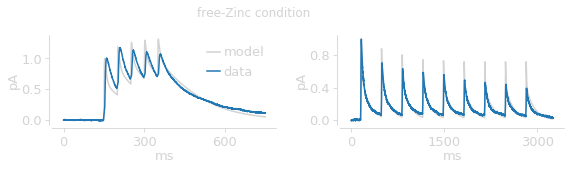

In [34]:
fig, AX = ge.figure(axes=(2,1), figsize=(1.2,0.8),
                    wspace=0.5, hspace=0)
Residual = 0

calib_data = npz_load('data/exp_data_for_calibration.npz')

mdata = npz_load(os.path.join('data/calib', best_zinc_config))

for cond, ax in zip(['20Hz_protocol', '3Hz_protocol'], AX):
    ## data
    tcond = (mdata['t']>(mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
        (mdata['t']<mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
         calib_data['DTfull_%s' % cond])
    
    trace_model = 1e3*(mdata['Ic'][tcond]-mdata['Ic'][tcond][0])
    trace_exp = calib_data['Iexp_zinc_%s' % cond]

    # normalizing to peak
    first_peak_cond = (calib_data['t_%s' % cond]<calib_data['DT0_%s' % cond]+30)
    norm_model = 1./np.max(trace_model[first_peak_cond])
    norm_exp = 1./np.max(trace_exp[first_peak_cond])
    
    Residual += np.sum((trace_model-trace_exp)**2)/len(calib_data['t_%s' % cond]) # normalized by sample size
    ax.plot(calib_data['t_%s' % cond], norm_model*trace_model, color=ge.default_color, label='model')
    ax.plot(calib_data['t_%s' % cond], norm_exp*trace_exp, color=ge.blue, label='data')

    ge.set_plot(ax, ylabel='pA', xlabel='ms')
ge.legend(AX[0])
fig.suptitle('free-Zinc condition', color=ge.default_color)
print(Residual)


In [15]:
from datavyz import ge

In [35]:
from analyz.IO.npz import load_dict
MDATA = {'free':load_dict(os.path.join('data/calib', best_zinc_config)),
         'chelated':load_dict(os.path.join('data/calib', best_chelated_config))}

In [437]:
np.savez('data/full_data_for_calibration.npz', **FDATA)

In [433]:
calib_data

{'DT0_20Hz_condition': 149.98,
 'DTfull_20Hz_condition': 749.98,
 't_20Hz_condition': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 7.496e+02, 7.497e+02,
        7.498e+02]),
 'Iexp_chelated_20Hz_condition': array([ 1.93865105,  2.77353563,  2.96108592, ..., 22.01194722,
        22.12031199, 21.95518374]),
 'Iexp_zinc_20Hz_condition': array([ 1.33181107e-01, -9.08029518e-03,  1.53594279e-02, ...,
         2.36453834e+01,  2.37376496e+01,  2.41585059e+01]),
 'DT0_3Hz_condition': 149.98,
 'DTfull_3Hz_condition': 3249.98,
 't_3Hz_condition': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 3.2496e+03, 3.2497e+03,
        3.2498e+03]),
 'Iexp_chelated_3Hz_condition': array([2.01901058, 1.79296788, 1.54664861, ..., 3.11079706, 3.23849109,
        3.27204658]),
 'Iexp_zinc_3Hz_condition': array([-0.8375646 , -0.89300291, -0.85717305, ...,  3.43563941,
         3.13738029,  2.91498914])}

NameError: name 'stim' is not defined

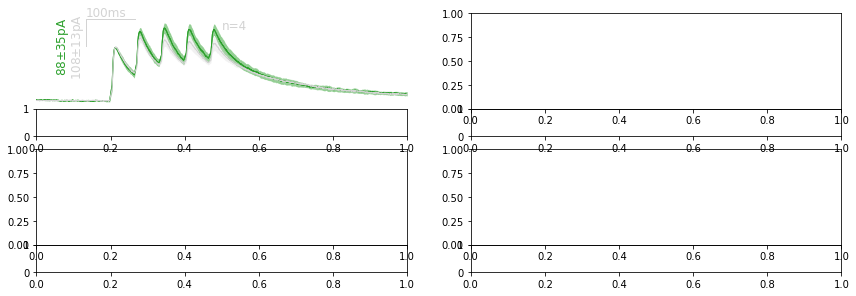

In [36]:

MDATA = load_dict('data/model-after-calib.npz')
FDATA = load_dict('data/full_data_for_calibration.npz')

fig, AX = ge.figure(axes_extents=[[[1,7],[1,7]],
                                  [[1,2],[1,2]],
                                  [[1,1],[1,1]],
                                  [[1,7],[1,7]],
                                  [[1,2],[1,2]]],
                    figsize=(1.55,0.12),
                    wspace=0.3, hspace=0, right=0.)

for ax in AX[2]:
    ax.axis('off')
    
for cond, ax, ax1, ax2, ax3, I0, t0, DI, T in zip(['20Hz_condition', '3Hz_condition'],
                                                  AX[0], AX[1], AX[3], AX[4], [1.5, 1.1],
                                        [100, 0], [0.5, 0.5], [100, 500]):

    ## exp
    ax.plot(FDATA[cond]['t'][0]+t0+np.zeros(2), [I0,I0-DI], lw=1, color=ge.default_color)
    ax.plot(FDATA[cond]['t'][0]+t0+np.arange(2)*T, [I0, I0], lw=1, color=ge.default_color)
    ge.annotate(ax, '%.0f$\pm$%.0fpA' % (1e3*FDATA[cond]['scale_ctrl'].mean()*DI,
                1e3*FDATA[cond]['scale_ctrl'].std()*DI),
                (FDATA[cond]['t'][0]+t0, I0-DI), xycoords='data', rotation=90,
                ha='right', va='center', size='small')
    ge.annotate(ax, '%.0f$\pm$%.0fpA\n' % (1e3*FDATA[cond]['scale_test'].mean()*DI,
                1e3*FDATA[cond]['scale_test'].std()*DI),
                (FDATA[cond]['t'][0]+t0, I0-DI), xycoords='data', rotation=90,
                ha='right', color=ge.green, va='center', size='small')
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_test'].mean(axis=0),
            sy=FDATA[cond]['norm_trace_test'].std(axis=0), ax=ax, color=ge.green)
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_test'].mean(axis=0),
            sy=FDATA[cond]['norm_trace_test'].std(axis=0), ax=ax, color=ge.green)
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_ctrl'].mean(axis=0),
            sy=FDATA[cond]['norm_trace_ctrl'].std(axis=0), ax=ax)
    ge.annotate(ax, 'n=%i' % len(FDATA[cond]['norm_trace_ctrl']), (.5,.8), size='small')
    ge.annotate(ax, '%ims' % T, (FDATA[cond]['t'][0]+t0, I0), xycoords='data', size='small')
    ge.set_plot(ax,[], xlim=[FDATA[cond]['t'][0], FDATA[cond]['t'][-1]])


    ## model
    DT0 = FDATA[cond]['t'][FDATA[cond]['se'][0]]-FDATA[cond]['t'][0]
    DTfull = FDATA[cond]['t'][-1]-FDATA[cond]['t'][0]

    YSCALE = 100
    tcond = (stim['t']>(stim['%s_tstart' % cond]-DT0)) &\
        (stim['t']<(stim['%s_tstart' % cond]-DT0+DTfull))
    for output, c in zip([MDATA['chelated'], MDATA['free']], [ge.green, ge.default_color]):
        trace = output['Ic'][tcond[1:]]-output['Ic'][tcond[1:]][0]
        tt = output['t'][tcond[1:]]
        ax2.plot(tt, 1e3*trace, color=c)
        
    ax2.plot(output['t'][tcond[1:]][0]-t[0]+t0+np.zeros(2), [.4*YSCALE, 1.4*YSCALE], lw=1, color=ge.default_color)
    ge.annotate(ax2, '%ipA' % YSCALE, (output['t'][tcond[1:]][0]-t[0]+t0, .4*YSCALE), xycoords='data', rotation=90, ha='right', va='bottom', size='small')
        
    ge.set_plot(ax2,[], xlim=[output['t'][tcond[1:]][0], output['t'][tcond[1:]][-1]])

    
    x, y = [output['t'][tcond[1:]][0]], [0]
    for e, n in zip(output['events'], output['Npicked']):
        x += [e,e,e]
        y += [0,1,0]
        ge.annotate(ax3, str(n), (e, 0.1), size='small', xycoords='data',
                    rotation=90, color=ge.purple)
    x += [output['t'][tcond[1:]][-1]]
    y += [0]
    x, y = np.array(x), np.array(y)
    tcond = (x>=output['t'][tcond[1:]][0]) & (x<=output['t'][tcond[1:]][-1])
    ax1.plot(x[tcond], y[tcond], 'k-', lw=1)
    ax3.plot(x[tcond], y[tcond], 'k-', lw=1)
    ge.set_plot(ax1,[], xlim=[x[tcond][0],x[tcond][-1]], ylim=[-.1,1.1])
    ge.set_plot(ax3,[], xlim=[x[tcond][0],x[tcond][-1]], ylim=[-.1,1.1])

ge.annotate(AX[0][0], 'Data', (.8,.5), italic=True, bold=True)
ge.annotate(AX[3][0], 'Model', (.8,.5), italic=True, bold=True)
ge.annotate(AX[1][0], 'electrical stim.', (1.,.1), ha='right', size='small')
ge.annotate(AX[4][0], 'synaptic act.', (1.,.1), ha='right', size='small', color=ge.purple)
#fig.savefig('figures/calibration.svg')    

In [441]:
MDATA['free'].keys()

dict_keys(['t', 'Vcmd', 'synapses_loc', 'Vm_soma', 'gAMPA_syn', 'X_syn', 'Vm_syn', 'bZn_syn', 'gNMDA_syn', 'Ic', '20Hz_condition_tstart', '3Hz_condition_tstart', 'events', 'Npicked'])